<a href="https://colab.research.google.com/github/YU-CHING-LAI/Robot_Learning/blob/main/RL_Assignment_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Robot Learning

## Assignment 9

### Solutions are due on 24.06.2025 before the lecture.

## Task 9.1)

Recall the discussion of the corresponding algorithm from the lecture and carefully read [Apprenticeship Learning via Inverse Reinforcement Learning](https://ai.stanford.edu/~ang/papers/icml04-apprentice.pdf) [Abbeel & Ng (2004)] to answer the following questions:

* (Yes/No - No reason required): Can a policy recovered by apprenticeship learning via IRL be optimal with respect to multiple reward functions?
* (Yes/No - No reason required): Can different policies lead to the same feature expectations?
* How many parameters are learned to approximate the reward function?
* How is available expert behaviour taken into account?
* What assumptions are made regarding the RL algorithm used to return optimal policies with respect to the approximated rewards?

<div style="text-align: right; font-weight:bold"> 1 + 1 + 2 + 2 + 2 = 8 Points </div>

Please answer in this text cell.



*   Yes
*   Yes
*   In the linear reward setting, the number of parameters equals the number of features.
*   Expert behavior is used to estimate the expert's feature expectations, which the algorithm then tries to match.
*   It is assumed that the RL algorithm can return near optimal policies for any given reward function.



## Task 9.2)

In the following task, we will again use an environment from Gym.

If you have started your Colab session and are ready to proceed, uncomment the four lines in the code cell below. They will install everything required to simulate the environment. If prompted to restart your runtime, do so, but you don't have to repeat the installation unless you delete your runtime.

**Warning: This is unlikely to work on your own computer, and might even mess up your system! Please only use the following lines in Colab.**

In [1]:
!apt-get -qq install xvfb x11-utils &> /dev/null
!pip install ufal.pybox2d --quiet &> /dev/null
!pip install pyvirtualdisplay moviepy pyglet PyOpenGL-accelerate --quiet &> /dev/null
!pip install numpy==1.23.5 matplotlib==3.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 92.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is in

### Introduction

In this task, we examine the Cart Pole environment.

Below, you are given an expert policy which selects the better of the two actions available per state. Note that the environment features a continuous 4-D state space, which we discretize by partioning the relevant regions into $8 \times 8 \times 8 \times 8$ bins. This allows use of tabular policies such as the expert to determine the better of the 2 actions per state. Familarize yourself with the corresponding discretization helper functions, the expert policy and the environment by examing the code below, which animates the expert policy playing one episode.

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Bin settings
NBINS = 8
NACTIONS = 2
# Dimension of the CartPole-v1 state space.
ENV_STATE_DIM =  4

### Discretization helper functions
# Helper function to create the bins
def create_bins(nbins=NBINS):
    """
    create bins to discretize the continuous observable state space
    """
    # NBINS X NBINS x NBINS x NBINS for
    # [cart_pos, cart_vel, pole_angle, pole_angular_vel]

    bins = np.zeros((ENV_STATE_DIM,nbins))
    bins[0] = np.linspace(-4.8, 4.8, nbins)
    bins[1] = np.linspace(-5, 5, nbins)
    bins[2] = np.linspace(-.418, .418, nbins)
    bins[3] = np.linspace(-5, 5, nbins)
    return bins

BINS = create_bins()

# Helper function to convert an environment state to a state_discrete containing bin indices
# You can directly access numpy arrays representing tabular Q or pi using the output
def discretize_state(state, bins=BINS):
    return tuple([np.digitize(state[i], bins[i]) - 1 for i in range(ENV_STATE_DIM)])

/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """
/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: DeprecationWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
  from scipy.ndimage.filters import sobel

  if event.key is 'enter':



In [2]:
# set up showing animations from the environment in Colab.
Display(visible=False).start()
# download the expert policy
!wget https://github.com/JanNogga/rl_ss25/raw/main/pi_expert.npy

--2025-06-23 23:07:35--  https://github.com/JanNogga/rl_ss25/raw/main/pi_expert.npy
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JanNogga/rl_ss25/main/pi_expert.npy [following]
--2025-06-23 23:07:35--  https://raw.githubusercontent.com/JanNogga/rl_ss25/main/pi_expert.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32896 (32K) [application/octet-stream]
Saving to: ‘pi_expert.npy’

pi_expert.npy       100%[===================>]  32.12K  --.-KB/s    in 0.01s   

2025-06-23 23:07:35 (2.95 MB/s) - ‘pi_expert.npy’ saved [32896/32896]



In [3]:
# load the expert policy
pi_expert = np.load('pi_expert.npy')
# Name of the environment.
ENV_NAME = 'CartPole-v1'
# Cart Pole has 2 discrete actions: [Push cart to the left, Push cart to the right]
ENV_ACTION_DIM = 1
# Create the environment
env = gym.make(ENV_NAME)
# Reset the environment
state = env.reset() # state = [cart_pos, cart_vel, pole_angle, pole_angular_vel]
# Track whether the episode is over
done = False
# List to append the frames produced by the environment renderer
frames = []
while not done:
  # Render current situation and append to frames
  frames.append(env.render('rgb_array'))
  # Select an action for the discretizied state according to the expert policy
  state_discrete = discretize_state(state)
  action = pi_expert[state_discrete]
  # Execute this action
  state, reward, done, info = env.step(action)
# Print the number of frames
print('Number of frames:', len(frames))
# Prevent the renderer from showing artifacts
plt.close()

Number of frames: 500


In [4]:
# Helper function to animate a list of frames as produced above
def visualize_trajectory(frames, fps=30):
  duration = int(len(frames) // fps + 1)
  fig, ax = plt.subplots()
  def make_frame(t, ind_max=len(frames)):
      ax.clear()
      ax.imshow(frames[min((int(fps*t),ind_max-1))])
      return mplfig_to_npimage(fig)
  plt.close()
  return VideoClip(make_frame, duration=duration)

In [5]:
# Get the animation from the frames of the played episode
animation = visualize_trajectory(frames)
# Show the animation
animation.ipython_display(fps=30, loop=True, autoplay=True)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Furthermore, you are given the code skeletons of several other helper functions below. Complete them by

* Implementing $$\phi: \mathcal{S} → [0,1]^4, \phi(s)=\phi(s_{(0)},s_{(1)},s_{(2)},s_{(3)}) \mapsto (f(s_{(0)}),f(s_{(1)}),f(s_{(2)}),f(s_{(3)}))$$ where $f$ is the sigmoid function.

* Implementing *feature_expectation()* which converts a policy represented by $\pi(s)$ or $Q^{\pi}(s,a)$ to $\mu_{\pi}$. Hint: refer to eq. (5) in [Abbeel & Ng (2004)].

* Completing the RL-algorithm (standard Q-learning) to use reward estimates instead of the rewards obtained from the environment. For the sake of the exercise assume that all we know about the environment is based on observing the expert policy perform.

<div style="text-align: right; font-weight:bold"> 2 + 3 + 2 = 7 Points </div>

In [6]:
def phi(state):
    # in: a (4,) numpy array containing the continous env state
    # out: a (4,1) numpy array containing the feature vector phi(s)
    return 1/(1 + np.exp(-state)).reshape(4, 1)

# You don't need to change this function
def selectActionEpsGreedy(Q, state_discrete, eps = 0.1):
    # in: Q values, a discrete_state and eps
    # out: action selected by the policy induced by Q
    if np.random.uniform() < eps:
        a = np.random.choice(NACTIONS)
    else:
        a = np.argmax(Q[state_discrete])
    return a

def feature_expectation(PiorQ, num_iterations=1000, gamma=0.9):
    # in: Q, an 8x8x8x8x2 numpy array OR
    # in: pi, an 8x8x8x8 numpy array
    # out: the (4,1) feature expectation for the input policy
    mu = np.zeros((4, 1))
    for _ in range(num_iterations):
        state = env.reset()
        done = False
        t = 0
        while not done:
            phi_s = phi(state)
            mu += (gamma ** t) * phi_s
            state_discrete = discretize_state(state)
            if PiorQ.ndim == 4:
                action = PiorQ[state_discrete]
            else:
                action = np.argmax(PiorQ[state_discrete])

            state, _, done, _ = env.step(action)
            t += 1
    return mu/num_iterations

# You only need to add a few lines here, look for TODO
def rl_algorithm(w=None, num_iterations=10000, gamma=0.9, alpha=0.02):
    # in: weights w to approximate rewards
    # out: Q values learned for w, and the corresponding learning curve
    Q = np.zeros((NBINS, NBINS, NBINS, NBINS, NACTIONS))
    returns_hist = np.zeros(num_iterations)
    for i in tqdm(range(num_iterations)):
        # reset the environment
        # do this before each new episode
        state_prev = env.reset()
        state_prev_discrete = discretize_state(state_prev)
        # done is used to indicate the end of an episode
        done = False
        # evaluate the episode
        k = 0
        while not done:
            k += 1
            # get the first action of the episode
            eps = 0.8/np.sqrt(1+i)
            a = selectActionEpsGreedy(Q, state_prev_discrete, eps = eps)
            # execute action a using the step function
            state, reward, done, _ = env.step(action = a)
            # at the end of the episode returns[i] is the return of the episode i
            # you might need this for debugging, so don't overwrite the rewards before this step
            returns_hist[i] += reward
            if w is not None:
                # we consider the task solved at 200 steps
                if k > 200:
                    done = True
                # TODO, overwrite the reward using w and phi
                phi_s = phi(state)
                reward = float(np.dot(w.T, phi_s))
            state_discrete = discretize_state(state)
            # get the max action a_prime
            a_prime = selectActionEpsGreedy(Q, state_discrete, eps = 0)
            # catch terminal states
            if done:
                Q_next = 0.
            else:
                Q_next = Q[state_discrete][a_prime]
            # update the Q-values, make sure you have overwritten reward by now
            Q[state_prev_discrete][a] += alpha*(reward + gamma * Q_next - Q[state_prev_discrete][a])
            # backup the current state
            state_prev_discrete = state_discrete
    return Q, returns_hist

## Task 9.3)

Use your results from the previous task to implement Apprenticeship Learning via Inverse Reinforcement Learning to estimate a reward function and find a policy which is optimal with respect to it based on observations of the expert. For ease of implementation, refer to section 3.1 in [Abbeel & Ng (2004)] to implement the algorithm using the projection method. Plot the learning curve of your final student policy and animate its behavior!

Hint: This algorithm is relatively straightforward to implement if you can get past the somewhat confusing cases for the epoch index $i$. In [Abbeel & Ng (2004)], section 3, the process is partitioned into 6 core steps. Step 1 is only used for initialization, and $i$ is set from 0 to 1 immediately after. Step 2 behaves differently for $i=1$, where $w$, $\overline{\mu}$ and $t$ append their first list elements as described towards the end of sec. 3.1. For $i\geq2$, step 2 proceeds according to the beginning of section 3.1.

<div style="text-align: right; font-weight:bold"> 5 Points </div>

100%|██████████| 10000/10000 [00:35<00:00, 278.85it/s]


Iteration 1, distance error: 1.2841


100%|██████████| 10000/10000 [00:11<00:00, 873.51it/s]


Iteration 2, distance error: 3.2651


100%|██████████| 10000/10000 [01:13<00:00, 135.18it/s]


Iteration 3, distance error: 0.0772


100%|██████████| 10000/10000 [00:16<00:00, 602.25it/s]


Iteration 4, distance error: 2.9801


100%|██████████| 10000/10000 [00:17<00:00, 564.34it/s]


Iteration 5, distance error: 2.5873


100%|██████████| 10000/10000 [00:23<00:00, 420.14it/s]


Iteration 6, distance error: 2.3802


100%|██████████| 10000/10000 [00:20<00:00, 484.32it/s]


Iteration 7, distance error: 2.6846


100%|██████████| 10000/10000 [00:16<00:00, 602.29it/s]


Iteration 8, distance error: 3.4472


100%|██████████| 10000/10000 [01:12<00:00, 137.06it/s]


Iteration 9, distance error: 0.0558


100%|██████████| 10000/10000 [00:13<00:00, 752.12it/s]


Iteration 10, distance error: 2.6994


100%|██████████| 10000/10000 [00:11<00:00, 874.84it/s]


Iteration 11, distance error: 3.2667


100%|██████████| 10000/10000 [00:09<00:00, 1020.98it/s]


Iteration 12, distance error: 4.5932


100%|██████████| 10000/10000 [01:12<00:00, 137.59it/s]


Iteration 13, distance error: 0.0723


100%|██████████| 10000/10000 [00:15<00:00, 643.23it/s]


Iteration 14, distance error: 2.5906


100%|██████████| 10000/10000 [00:14<00:00, 676.74it/s]


Iteration 15, distance error: 2.4720


100%|██████████| 10000/10000 [00:10<00:00, 965.76it/s]


Iteration 16, distance error: 4.6073


100%|██████████| 10000/10000 [01:17<00:00, 128.41it/s]


Converged at iteration 17, distance error: 0.0092


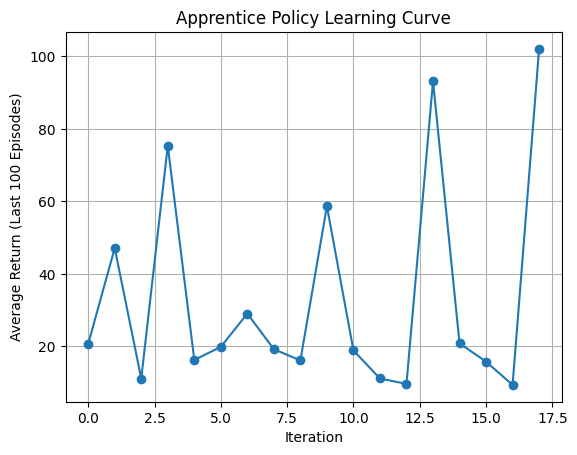

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [9]:
# Your code can go here

def projection_IRL(epsilon=0.05, max_iter=20, gamma=0.9):
    mu_E = feature_expectation(pi_expert, gamma=gamma)
    mu_list = []
    t_list = []
    w_list = []
    Q_list = []
    returns_list = []
    Q0, returns0 = rl_algorithm(w=None)
    mu_0 = feature_expectation(Q0, gamma=gamma)
    mu_list.append(mu_0)
    t_list.append(mu_0)
    w1 = mu_E - mu_0
    w1 /= np.linalg.norm(w1)
    w_list.append(w1)
    Q_list.append(Q0)
    returns_list.append(np.mean(returns0[-100:]))

    for i in range(1, max_iter):
        w = mu_E - t_list[-1]
        w /= np.linalg.norm(w)
        w_list.append(w)
        Q, returns = rl_algorithm(w=w, gamma=gamma)
        mu_i = feature_expectation(Q, gamma=gamma)
        mu_list.append(mu_i)
        Q_list.append(Q)
        returns_list.append(np.mean(returns[-100:]))
        delta = mu_i - t_list[-1]
        numerator = np.dot((mu_E - t_list[-1]).T, delta)
        denominator = np.dot(delta.T, delta)
        coeff = numerator / denominator
        t_i = t_list[-1] + coeff * delta
        t_list.append(t_i)
        distance = np.linalg.norm(mu_E - mu_i)
        if distance < epsilon:
            print(f"Converged at iteration {i}, distance error: {distance:.4f}")
            break
        else:
            print(f"Iteration {i}, distance error: {distance:.4f}")
    return Q_list, returns_list

def plot_learning_curve(returns_list):
    plt.plot(returns_list, marker='o')
    plt.title("Apprentice Policy Learning Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Average Return (Last 100 Episodes)")
    plt.grid(True)
    plt.show()

def animate_policy(Q, fps=15, num_episodes=5, max_steps=300):
    frames = []
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        steps = 0
        while not done and steps < max_steps:
            frames.append(env.render('rgb_array'))
            state_discrete = discretize_state(state)
            action = np.argmax(Q[state_discrete])
            state, _, done, _ = env.step(action)
            steps += 1
    animation = visualize_trajectory(frames, fps=fps)
    animation.ipython_display(fps=fps, loop=True, autoplay=True)


Q_list, returns_list = projection_IRL(epsilon=0.05, max_iter=20)
plot_learning_curve(returns_list)
animate_policy(Q_list[-1], fps=15, num_episodes=1, max_steps=300)

In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import Video
video = Video("__temp__.mp4", embed=True)
display(video)